In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.path import Path
from numpy import arange

from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.poly import create_vertice
import re
from datetime import datetime, timedelta

from matplotlib.animation import FuncAnimation
from numpy import arange, isnan, meshgrid, ones

from py_eddy_tracker import start_logger
from py_eddy_tracker.data import get_demo_path
from py_eddy_tracker.dataset.grid import GridCollection, _fit_circle_path
from py_eddy_tracker.observations.observation  import EddiesObservations
from py_eddy_tracker.gui import GUI_AXES
from py_eddy_tracker.generic import uniform_resample, coordinates_to_local
from py_eddy_tracker.poly import create_vertice, poly_area, visvalingam

from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.cm as cm

from typing import List, Tuple

In [3]:

class eddy_detection():
    def __init__(self, dataset_path: str, lat: list, lon: list):
        self.path = dataset_path
        self.data: List[Tuple] = self.load_data()
        self.hours_since_start_list: list = []
        self.grid_list: List[RegularGridDataset] = []
        self.days_list: list = [] 
        self.lat: list = lat
        self.lon: list = lon
        self.anticyclonic_list: list = []
        self.cyclonic_list: list = []
        return None
    
    def start_axes(self, title):
        fig = plt.figure(figsize=(13, 5))
        ax = fig.add_axes([0.03, 0.03, 0.90, 0.94])
        ax.set_xlim(self.lon[0], self.lon[1]), ax.set_ylim(self.lat[0], self.lat[1])
        ax.set_aspect("equal")
        ax.set_title(title, weight="bold")
        return ax


    def update_axes(self, ax, mappable=None):
        ax.grid()
        if mappable:
            plt.colorbar(mappable, cax=ax.figure.add_axes([0.94, 0.05, 0.01, 0.9]))

    def load_data(self):
        grid_collection = GridCollection.from_netcdf_cube(
            self.path,
            "LONGITUDE",
            "LATITUDE",
            "TIME",
            heigth="ssh")
        return grid_collection.datasets
    
    def create_list_dataset(self, days_list: List):
        self.days_list = days_list
        for day in self.days_list:
            hours, g = self.data[day-1]
            g.vars['ssh'] = np.ma.array(g.vars['ssh'], mask=np.isnan(g.vars['ssh']))
            g.add_uv("ssh")
            self.hours_since_start_list.append(hours)
            self.grid_list.append(g)

    def plot_graph(self, days:list):
        for day in days:
            ax = self.start_axes("SSH (m)")
            m = self.grid_list[day-1].display(ax, "ssh", vmin=-1, vmax=1, cmap="RdBu_r")
            self.update_axes(ax, m)
        return None
    def detect_eddies(self, min_pixel : int = 30):
        for day in self.days_list:
            date = datetime(1950, 1 , 1) + timedelta(hours=int(self.hours_since_start_list[day-1])) // 1
            a, c = self.grid_list[day-1].eddy_identification("ssh", "u", "v", date, 0.002, pixel_limit=(min_pixel, 2000), shape_error=70)
            self.anticyclonic_list.append(a)
            self.cyclonic_list.append(c)
        return None
    def plot_detected_eddies(self, days:list):
        for day in days:
            ax = self.start_axes("Detected Eddies")
            self.anticyclonic_list[day - 1].display(
                ax, color="r", linewidth=0.75, label="Anticyclonic ({nb_obs} eddies)", ref=-70
            )
            self.cyclonic_list[day - 1].display(ax, color="b", linewidth=0.75, label="Cyclonic ({nb_obs} eddies)", ref=-70)
            ax.legend()
            self.update_axes(ax)
        return None
            
        
            
            
        
    

In [4]:
def generate_pixel_eddy(eddy_class, day):
    g = eddy_class.grid_list[day-1]
    a = eddy_class.anticyclonic_list[day-1]
    c = eddy_class.cyclonic_list[day-1]
    ssh = g.grid("ssh")
    mask_a = np.zeros(ssh.shape, dtype="bool")
    x_a_name, y_a_name = a.intern(True)
    mask_c = np.zeros(ssh.shape, dtype="bool")
    x_c_name, y_c_name = c.intern(True)

    for eddy in a:
        i, j = Path(create_vertice(eddy[x_a_name], eddy[y_a_name])).pixels_in(g)
        mask_a[i, j] = True

    for eddy in c:
        i, j = Path(create_vertice(eddy[x_c_name], eddy[y_c_name])).pixels_in(g)
        mask_c[i, j] = True
    return mask_a, mask_c


In [5]:
def masking(eddy_class):
    masked_anticylonic = []
    masked_cyclonic = []
    masked_total = []
    for day in days:
        mask_a, mask_c = generate_pixel_eddy(eddy_class, day)
        masked_anticylonic.append(mask_a)
        masked_cyclonic.append(mask_c)
        masked_total.append(2 * mask_a + 1 * mask_c)
    masked_3d = np.dstack(masked_total)
    masked_3d = np.rollaxis(masked_3d,-1)
    return masked_3d

In [6]:
def filtering(eddy_class, days):
    filter_total = []
    for day in days:
        filter_total.append(eddy_class.grid_list[day-1].grid('ssh'))
    filter_3d = np.dstack(filter_total)
    filter_3d = np.rollaxis(filter_3d,-1)
    return filter_3d

In [8]:
from numpy import sinc, pi, sin, cos, arctan2, empty, ma, ceil, errstate
from scipy.special import j1
from cv2 import filter2D

In [31]:
# #Time fix for SSH using SEG data
# days_dict = {0:0, 1:31, 2:59 ,3:90, 4:120, 5:151, 6:181, 7:212, 8:243, 9:273, 10:304, 11:334, 12:365}
# for j in range(1, 4): #years
#     for i in range(1, 13): #months
#         data_addr_nn = "/home/ollie/ssunar/ssh_filtered/ssh_gridded_196"+str(j)+"_001_"+str(i).zfill(2)+"_new.nc"
#         seg_data_addr_nn = "/home/ollie/ssunar/segmentation_masks_3_years/segmentation_mask_nn_196"+str(j)+"_001_"+str(i).zfill(2)+"_new.nc"
#         time = None
#         with Dataset(data_addr_nn, "a") as true_ds:
#             with Dataset(seg_data_addr_nn, "r") as seg_ds:
#                 time = seg_ds['TIME'][:]
#             true_ds['TIME'][:] = time
#             #true_ds['TIME'][:] += days_dict[i-1] * 24

In [32]:
dd = "/home/ollie/ssunar/nn_interpolation_new/ssh_gridded_1961_001_02_new.nc"
true_ds = xr.open_dataset(dd)
true_ds['TIME'][:]

<xarray.DataArray 'TIME' (TIME: 28)>
array([97199.93, 97223.93, 97247.93, 97271.93, 97295.93, 97319.93, 97343.93,
       97367.93, 97391.93, 97415.93, 97439.93, 97463.93, 97487.93, 97511.93,
       97535.93, 97559.93, 97583.93, 97607.93, 97631.93, 97655.93, 97679.93,
       97703.93, 97727.93, 97751.93, 97775.93, 97799.93, 97823.93, 97847.93],
      dtype=float32)
Coordinates:
  * TIME     (TIME) float32 9.72e+04 9.722e+04 9.725e+04 ... 9.782e+04 9.785e+04
Attributes:
    unit:     hours since 1950-01-01 00:00:00

In [7]:
#daywise eddy observation object creation and segmask saving monthwise
import os
for j in range(1, 2): #years
        
    for i in range(1, 2): #months
        data_addr_nn = '/albedo/home/ssunar/ssh_filtered/months/ssh_filtered_gridded_196'+str(j)+'_001_'+str(i).zfill(2)+'.nc'
        ds = xr.open_dataset(data_addr_nn)
        lon = [ds["LONGITUDE"].values.min(), ds["LONGITUDE"].values.max()] 
        lat = [ds["LATITUDE"].values.min() , ds["LATITUDE"].values.max()]

        last_day = ds["TIME"].size
        days = list(range(1, last_day + 1))
        eddy_class = eddy_detection(dataset_path=data_addr_nn, lat=lat, lon=lon)
        
        eddy_class.create_list_dataset(days)
#         for day in days:
#             lon = eddy_class.grid_list[day-1].x_c
#             lon[lon<0] +=360
#             eddy_class.grid_list[day-1].x_c =lon
        eddy_class.detect_eddies()
        print(last_day)
        masked_3d_array = masking(eddy_class)
        ds_mask = ds.copy(deep = True)
        ds_mask["seg_mask"] = ("TIME", "LONGITUDE", "LATITUDE"), masked_3d_array
        ds_mask = ds_mask.drop("ssh")

        outfile = "/albedo/home/ssunar/temp/segmentation_mask_nn_196"+str(j)+"_001_"+str(i).zfill(2)+".nc"
        if os.path.isfile(outfile):
            os.remove(outfile)
        ds_mask.to_netcdf(outfile)
        
        for k in range(last_day):
            a = eddy_class.anticyclonic_list[k]
            c = eddy_class.cyclonic_list[k]
            a.time[:] //= 1
            c.time[:] //= 1
            date = datetime(1960 + j, i, k+1)
            with Dataset(date.strftime("/albedo/home/ssunar/temp/Anticyclonic_%Y%m%d.nc"), "w") as h:
                #file_a_pred_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_true/Anticyclonic_%Y%m%d.nc"))
                a.to_netcdf(h)
            with Dataset(date.strftime("/albedo/home/ssunar/temp/Cyclonic_%Y%m%d.nc"), "w") as h:
                #file_c_pred_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_true/Cyclonic_%Y%m%d.nc"))
                c.to_netcdf(h)
        

We assume pixel position of grid is centered for /albedo/home/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assume pixel position of grid is centered for /albedo/home/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assume pixel position of grid is centered for /albedo/home/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assume pixel position of grid is centered for /albedo/home/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assume pixel position of grid is centered for /albedo/home/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assume pixel position of grid is centered for /albedo/home/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assume pixel position of grid is centered for /albedo/home/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assume pixel position of grid is centered for /albedo/home/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc


31


/albedo/home/ssunar/py-eddy-tracker/src/py_eddy_tracker/observations/observation.py:1619: RuntimeWarning: overflow encountered in true_divide
  var[:] = data


In [ ]:
#daywise eddy observation object creation and segmask saving monthwise
import os
for j in range(1, 2): #years
        
    for i in range(1, 2): #months
        data_addr_nn = '/home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_196'+str(j)+'_001_'+str(i).zfill(2)+'.nc'
        ds = xr.open_dataset(data_addr_nn)
        lon = [ds["LONGITUDE"].values.min(), ds["LONGITUDE"].values.max()]
        lat = [ds["LATITUDE"].values.min(), ds["LATITUDE"].values.max()]

        last_day = ds["TIME"].size
        days = list(range(1, last_day + 1))
        eddy_class = eddy_detection(dataset_path=data_addr_nn, lat=lat, lon=lon)
        eddy_class.create_list_dataset(days)
        eddy_class.detect_eddies()
        print(last_day)
        masked_3d_array = masking(eddy_class)
        ds_mask = ds.copy(deep = True)
        ds_mask["seg_mask"] = ("TIME", "LONGITUDE", "LATITUDE"), masked_3d_array
        ds_mask = ds_mask.drop("ssh")

        outfile = "/home/ollie/ssunar/segmentation_masks_3_years/segmentation_mask_nn_196"+str(j)+"_001_"+str(i).zfill(2)+".nc"
        if os.path.isfile(outfile):
            os.remove(outfile)
        ds_mask.to_netcdf(outfile)
        
        for k in range(last_day):
            a = eddy_class.anticyclonic_list[k]
            c = eddy_class.cyclonic_list[k]
            a.time[:] //= 1
            c.time[:] //= 1
            date = datetime(1960 + j, i, k+1)
            with Dataset(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_true/Anticyclonic_%Y%m%d.nc"), "w") as h:
                #file_a_pred_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_true/Anticyclonic_%Y%m%d.nc"))
                a.to_netcdf(h)
            with Dataset(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_true/Cyclonic_%Y%m%d.nc"), "w") as h:
                #file_c_pred_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_true/Cyclonic_%Y%m%d.nc"))
                c.to_netcdf(h)
        

We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assum

31


/home/ollie/ssunar/py-eddy-tracker/src/py_eddy_tracker/observations/observation.py:1624: RuntimeWarning: overflow encountered in true_divide
  var[:] = data
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_02.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_02.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_02.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_02.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_02.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_02.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtere

28


We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_03.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_03.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_03.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_03.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_03.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_03.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_03.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_03.nc
We assum

31


We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_04.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_04.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_04.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_04.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_04.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_04.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_04.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_04.nc
We assum

30


We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_05.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_05.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_05.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_05.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_05.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_05.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_05.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_05.nc
We assum

31


We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_06.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_06.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_06.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_06.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_06.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_06.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_06.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_06.nc
We assum

30


We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_07.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_07.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_07.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_07.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_07.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_07.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_07.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_07.nc
We assum

31


We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_08.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_08.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_08.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_08.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_08.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_08.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_08.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_08.nc
We assum

31


We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_09.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_09.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_09.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_09.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_09.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_09.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_09.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_09.nc
We assum

30


We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_10.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_10.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_10.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_10.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_10.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_10.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_10.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_10.nc
We assum

31


We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_11.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_11.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_11.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_11.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_11.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_11.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_11.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_11.nc
We assum

30


We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_12.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_12.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_12.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_12.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_12.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_12.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_12.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_12.nc
We assum

31


We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_01.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_01.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_01.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_01.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_01.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_01.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_01.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_01.nc
We assum

31


We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_02.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_02.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_02.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_02.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_02.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_02.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_02.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_02.nc
We assum

28


We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_03.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_03.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_03.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_03.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_03.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_03.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_03.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_03.nc
We assum

31


We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_04.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_04.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_04.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_04.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_04.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_04.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_04.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_04.nc
We assum

30


We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_05.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_05.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_05.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_05.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_05.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_05.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_05.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_05.nc
We assum

31


We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_06.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_06.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_06.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_06.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_06.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_06.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_06.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_06.nc
We assum

30


We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_07.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_07.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_07.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_07.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_07.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_07.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_07.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_07.nc
We assum

31


We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_08.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_08.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_08.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_08.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_08.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_08.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_08.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_08.nc
We assum

31


We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_09.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_09.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_09.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_09.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_09.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_09.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_09.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_09.nc
We assum

30


We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_10.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_10.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_10.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_10.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_10.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_10.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_10.nc
We assume pixel position of grid is centered for /home/ollie/ssunar/ssh_filtered/months/ssh_filtered_gridded_1962_001_10.nc
We assum

In [41]:
lon

[-70.0, 29.916666]

In [2]:
#filtering
import os
for j in range(1, 2):
    for i in range(1, 2):
        data_addr_nn = '/home/ollie/ssunar/nn_interpolation_new/ssh_gridded_196'+str(j)+'_001_'+str(i).zfill(2)+'_new.nc'
        ds = xr.open_dataset(data_addr_nn)
        lon = [ds["LONGITUDE"].values.min(), ds["LONGITUDE"].values.max()]
        lat = [ds["LATITUDE"].values.min(), ds["LATITUDE"].values.max()]

        last_day = ds["TIME"].size
        days = list(range(1, last_day + 1))
        eddy_class = eddy_detection(dataset_path=data_addr_nn, lat=lat, lon=lon)
        eddy_class.create_list_dataset(days)
        print(last_day)
        ssh_filtered_3d_array = filtering(eddy_class, days)

        ds_mask = ds.copy(deep = True)
        ds_mask = ds_mask.drop("ssh")
        ds_mask["ssh"] = ("TIME", "LONGITUDE", "LATITUDE"), ssh_filtered_3d_array

        outfile = '/home/ollie/ssunar/ssh_filtered/ssh_gridded_196'+str(j)+'_001_'+str(i).zfill(2)+"_new.nc"
        if os.path.isfile(outfile):
            os.remove(outfile)
        ds_mask.to_netcdf(outfile)
        print(i)

NameError: name 'xr' is not defined

In [ ]:
#filtering
import os
for j in range(1, 2):
    for i in range(1, 2):
        data_addr_nn = '/home/ollie/ssunar/nn_interpolation_new/ssh_gridded_196'+str(j)+'_001_'+str(i).zfill(2)+'_new.nc'
        ds = xr.open_dataset(data_addr_nn)
        lon = [ds["LONGITUDE"].values.min(), ds["LONGITUDE"].values.max()]
        lat = [ds["LATITUDE"].values.min(), ds["LATITUDE"].values.max()]

        last_day = ds["TIME"].size
        days = list(range(1, 1 + 1))
        eddy_class = eddy_detection(dataset_path=data_addr_nn, lat=lat, lon=lon)
        eddy_class.create_list_dataset(days)
        

In [11]:
'''
import os

data_addr_nn = '/work/ollie/bpanthi/test_NN/ssh_gridded_1961_001_1_new.nc'
ds = xr.open_dataset(data_addr_nn)
lon = [ds["LONGITUDE"].values.min(), ds["LONGITUDE"].values.max()]
lat = [ds["LATITUDE"].values.min(), ds["LATITUDE"].values.max()]

last_day = ds["TIME"].size
days = list(range(1, last_day + 1))
eddy_class = eddy_detection(dataset_path=data_addr_nn, lat=lat, lon=lon)
eddy_class.create_list_dataset(days)
eddy_class.detect_eddies()
masked_3d_array = masking(eddy_class)

ds_mask = ds.copy(deep = True)
ds_mask["seg_mask"] = ("TIME", "LONGITUDE", "LATITUDE"), masked_3d_array
ds_mask = ds_mask.drop("ssh")

outfile = "/home/ollie/ssunar/segmentation_masks_test/segmentation_mask_nn_1961_001_test.nc"
if os.path.isfile(outfile):
    os.remove(outfile)
ds_mask.to_netcdf(outfile)
'''

'\nimport os\n\ndata_addr_nn = \'/work/ollie/bpanthi/test_NN/ssh_gridded_1961_001_1_new.nc\'\nds = xr.open_dataset(data_addr_nn)\nlon = [ds["LONGITUDE"].values.min(), ds["LONGITUDE"].values.max()]\nlat = [ds["LATITUDE"].values.min(), ds["LATITUDE"].values.max()]\n\nlast_day = ds["TIME"].size\ndays = list(range(1, last_day + 1))\neddy_class = eddy_detection(dataset_path=data_addr_nn, lat=lat, lon=lon)\neddy_class.create_list_dataset(days)\neddy_class.detect_eddies()\nmasked_3d_array = masking(eddy_class)\n\nds_mask = ds.copy(deep = True)\nds_mask["seg_mask"] = ("TIME", "LONGITUDE", "LATITUDE"), masked_3d_array\nds_mask = ds_mask.drop("ssh")\n\noutfile = "/home/ollie/ssunar/segmentation_masks_test/segmentation_mask_nn_1961_001_test.nc"\nif os.path.isfile(outfile):\n    os.remove(outfile)\nds_mask.to_netcdf(outfile)\n'

In [33]:
import os
for i in range(1,2):
    data_addr_nn = '/work/ollie/ssunar/nn_interpolation_new/ssh_gridded_1961_001_'+str(i).zfill(2)+'_new.nc'
    ds = xr.open_dataset(data_addr_nn)
    lon = [ds["LONGITUDE"].values.min(), ds["LONGITUDE"].values.max()]
    lat = [ds["LATITUDE"].values.min(), ds["LATITUDE"].values.max()]

    last_day = ds["TIME"].size
    days = list(range(1, last_day + 1))
    eddy_class = eddy_detection(dataset_path=data_addr_nn, lat=lat, lon=lon)
    eddy_class.create_list_dataset(days)
    print(last_day)
    eddy_class.detect_eddies()
    masked_3d_array = masking(eddy_class)

    ds_mask = ds.copy(deep = True)
    ds_mask["seg_mask"] = ("TIME", "LONGITUDE", "LATITUDE"), masked_3d_array
    ds_mask = ds_mask.drop("ssh")

    outfile = "/home/ollie/ssunar/segmentation_masks_3_years/segmentation_mask_nn_1961_001_"+str(i).zfill(2)+"_new.nc"
    if os.path.isfile(outfile):
        os.remove(outfile)
    ds_mask.to_netcdf(outfile)
    print(i)

We assume pixel position of grid is centered for /work/ollie/ssunar/nn_interpolation_new/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/ssunar/nn_interpolation_new/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/ssunar/nn_interpolation_new/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/ssunar/nn_interpolation_new/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/ssunar/nn_interpolation_new/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/ssunar/nn_interpolation_new/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/ssunar/nn_interpolation_new/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/ssunar/nn_interpolation_new/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is cent

31
1


In [13]:
import os
#lat = [-60, -20]
#lon = [-70, 30]
for i in range(1,13):
    data_addr_nn = '/work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_'+str(i).zfill(2)+'_new.nc'
    ds = xr.open_dataset(data_addr_nn)
    lon = [ds["LONGITUDE"].values.min(), ds["LONGITUDE"].values.max()]
    lat = [ds["LATITUDE"].values.min(), ds["LATITUDE"].values.max()]
    last_day = ds["TIME"].size
    days = list(range(1, last_day + 1))
    eddy_class = eddy_detection(dataset_path=data_addr_nn, lat=lat, lon=lon)
    eddy_class.create_list_dataset(days)
    eddy_class.detect_eddies()
    masked_3d_array = masking(eddy_class)
    
    ds_mask = ds.copy(deep = True)
    ds_mask["seg_mask"] = ("TIME", "LONGITUDE", "LATITUDE"), masked_3d_array
    ds_mask = ds_mask.drop("ssh")

    outfile = "/home/ollie/ssunar/segmentation_masks_NN_kursaal_70_err/segmentation_mask_nn_1961_001_"+str(i).zfill(2)+"_new.nc"
    if os.path.isfile(outfile):
        os.remove(outfile)
    ds_mask.to_netcdf(outfile)
    print(i)
    

We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_01_new.nc
W

1


We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_02_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_02_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_02_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_02_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_02_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_02_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_02_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_02_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_02_new.nc
W

2


We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_03_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_03_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_03_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_03_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_03_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_03_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_03_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_03_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_03_new.nc
W

3


We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_04_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_04_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_04_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_04_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_04_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_04_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_04_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_04_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_04_new.nc
W

4


We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_05_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_05_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_05_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_05_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_05_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_05_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_05_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_05_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_05_new.nc
W

5


We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_06_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_06_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_06_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_06_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_06_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_06_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_06_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_06_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_06_new.nc
W

6


We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_07_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_07_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_07_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_07_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_07_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_07_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_07_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_07_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_07_new.nc
W

7


We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_08_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_08_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_08_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_08_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_08_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_08_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_08_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_08_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_08_new.nc
W

8


We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_09_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_09_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_09_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_09_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_09_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_09_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_09_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_09_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_09_new.nc
W

9


We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_10_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_10_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_10_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_10_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_10_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_10_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_10_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_10_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_10_new.nc
W

10


We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_11_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_11_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_11_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_11_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_11_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_11_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_11_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_11_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_11_new.nc
W

11


We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_12_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_12_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_12_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_12_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_12_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_12_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_12_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_12_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/NN_kursaal/ssh_gridded_1961_001_12_new.nc
W

12


In [5]:
for m in range(1, 12):
    days = list(range(1, 29))
    eddy_class_list[m-1].create_list_dataset(days)

In [11]:
days

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28]

In [ ]:
for m in range(1, 12):
    eddy_class_list[m-1].detect_eddies()

1961-01-01 23:00:00
1961-01-02 23:00:00


No extrema found in contour of 4 pixels in level 0.026000


1961-01-03 23:00:00
1961-01-04 23:00:00


No extrema found in contour of 4 pixels in level 0.212000


1961-01-05 23:00:00


No extrema found in contour of 5 pixels in level -0.216000


1961-01-06 23:00:00
1961-01-07 23:00:00
1961-01-08 23:00:00
1961-01-09 23:00:00
1961-01-10 23:00:00
1961-01-11 23:00:00
1961-01-12 23:00:00
1961-01-13 23:00:00


No extrema found in contour of 4 pixels in level 0.170000


1961-01-14 23:00:00
1961-01-15 23:00:00
1961-01-16 23:00:00
1961-01-17 23:00:00


No extrema found in contour of 5 pixels in level 0.002000


1961-01-18 23:00:00
1961-01-19 23:00:00
1961-01-20 23:00:00


No extrema found in contour of 5 pixels in level 0.002000


1961-01-21 23:00:00
1961-01-22 23:00:00
1961-01-23 23:00:00
1961-01-24 23:00:00
1961-01-25 23:00:00


No extrema found in contour of 4 pixels in level -0.034000


1961-01-26 23:00:00
1961-01-27 23:00:00
1961-01-28 23:00:00
1961-01-01 23:00:00
1961-01-02 23:00:00
1961-01-03 23:00:00
1961-01-04 23:00:00
1961-01-05 23:00:00
1961-01-06 23:00:00
1961-01-07 23:00:00
1961-01-08 23:00:00


No extrema found in contour of 4 pixels in level -0.168000


1961-01-09 23:00:00
1961-01-10 23:00:00
1961-01-11 23:00:00
1961-01-12 23:00:00
1961-01-13 23:00:00
1961-01-14 23:00:00
1961-01-15 23:00:00
1961-01-16 23:00:00
1961-01-17 23:00:00


No extrema found in contour of 4 pixels in level -0.092000


1961-01-18 23:00:00


No extrema found in contour of 4 pixels in level -0.316000


1961-01-19 23:00:00
1961-01-20 23:00:00
1961-01-21 23:00:00
1961-01-22 23:00:00
1961-01-23 23:00:00
1961-01-24 23:00:00
1961-01-25 23:00:00
1961-01-26 23:00:00


No extrema found in contour of 4 pixels in level -0.020000


1961-01-27 23:00:00
1961-01-28 23:00:00
1961-01-01 23:00:00
1961-01-02 23:00:00
1961-01-03 23:00:00


No extrema found in contour of 4 pixels in level -0.020000
No extrema found in contour of 7 pixels in level 0.014000


1961-01-04 23:00:00


No extrema found in contour of 4 pixels in level -0.274000


1961-01-05 23:00:00
1961-01-06 23:00:00
1961-01-07 23:00:00
1961-01-08 23:00:00


No extrema found in contour of 4 pixels in level 0.002000


1961-01-09 23:00:00
1961-01-10 23:00:00
1961-01-11 23:00:00
1961-01-12 23:00:00


No extrema found in contour of 4 pixels in level 0.094000


1961-01-13 23:00:00
1961-01-14 23:00:00


No extrema found in contour of 4 pixels in level 0.006000


1961-01-15 23:00:00
1961-01-16 23:00:00
1961-01-17 23:00:00
1961-01-18 23:00:00


No extrema found in contour of 4 pixels in level 0.000000


1961-01-19 23:00:00
1961-01-20 23:00:00
1961-01-21 23:00:00


No extrema found in contour of 4 pixels in level -0.010000
No extrema found in contour of 5 pixels in level -0.068000


1961-01-22 23:00:00
1961-01-23 23:00:00
1961-01-24 23:00:00
1961-01-25 23:00:00
1961-01-26 23:00:00
1961-01-27 23:00:00
1961-01-28 23:00:00
1961-01-01 23:00:00
1961-01-02 23:00:00


No extrema found in contour of 4 pixels in level 0.032000


1961-01-03 23:00:00
1961-01-04 23:00:00
1961-01-05 23:00:00
1961-01-06 23:00:00
1961-01-07 23:00:00
1961-01-08 23:00:00
1961-01-09 23:00:00
1961-01-10 23:00:00


No extrema found in contour of 4 pixels in level 0.048000


1961-01-11 23:00:00
1961-01-12 23:00:00


No extrema found in contour of 4 pixels in level -0.078000


1961-01-13 23:00:00
1961-01-14 23:00:00
1961-01-15 23:00:00
1961-01-16 23:00:00


No extrema found in contour of 8 pixels in level 0.182000
No extrema found in contour of 7 pixels in level 0.184000
No extrema found in contour of 7 pixels in level 0.186000


1961-01-17 23:00:00


No extrema found in contour of 4 pixels in level -0.050000


1961-01-18 23:00:00
1961-01-19 23:00:00
1961-01-20 23:00:00
1961-01-21 23:00:00
1961-01-22 23:00:00


No extrema found in contour of 5 pixels in level -0.130000


1961-01-23 23:00:00


No extrema found in contour of 4 pixels in level -0.008000


1961-01-24 23:00:00
1961-01-25 23:00:00
1961-01-26 23:00:00
1961-01-27 23:00:00


No extrema found in contour of 4 pixels in level -0.026000


1961-01-28 23:00:00


No extrema found in contour of 5 pixels in level 0.014000
No extrema found in contour of 5 pixels in level -0.008000


1961-01-01 23:00:00
1961-01-02 23:00:00
1961-01-03 23:00:00
1961-01-04 23:00:00


No extrema found in contour of 4 pixels in level 0.044000


1961-01-05 23:00:00
1961-01-06 23:00:00


No extrema found in contour of 4 pixels in level 0.000000


1961-01-07 23:00:00
1961-01-08 23:00:00
1961-01-09 23:00:00
1961-01-10 23:00:00
1961-01-11 23:00:00
1961-01-12 23:00:00


No extrema found in contour of 4 pixels in level -0.032000


1961-01-13 23:00:00
1961-01-14 23:00:00
1961-01-15 23:00:00
1961-01-16 23:00:00


No extrema found in contour of 4 pixels in level 0.034000


1961-01-17 23:00:00
1961-01-18 23:00:00
1961-01-19 23:00:00
1961-01-20 23:00:00
1961-01-21 23:00:00
1961-01-22 23:00:00


No extrema found in contour of 4 pixels in level -0.004000


1961-01-23 23:00:00


No extrema found in contour of 5 pixels in level -0.020000


1961-01-24 23:00:00
1961-01-25 23:00:00
1961-01-26 23:00:00
1961-01-27 23:00:00
1961-01-28 23:00:00
1961-01-01 23:00:00
1961-01-02 23:00:00
1961-01-03 23:00:00
1961-01-04 23:00:00
1961-01-05 23:00:00
1961-01-06 23:00:00
1961-01-07 23:00:00
1961-01-08 23:00:00
1961-01-09 23:00:00
1961-01-10 23:00:00
1961-01-11 23:00:00
1961-01-12 23:00:00


No extrema found in contour of 6 pixels in level 0.028000


1961-01-13 23:00:00
1961-01-14 23:00:00
1961-01-15 23:00:00


No extrema found in contour of 4 pixels in level 0.004000
No extrema found in contour of 4 pixels in level -0.088000


1961-01-16 23:00:00
1961-01-17 23:00:00
1961-01-18 23:00:00
1961-01-19 23:00:00
1961-01-20 23:00:00
1961-01-21 23:00:00


No extrema found in contour of 4 pixels in level -0.002000


1961-01-22 23:00:00
1961-01-23 23:00:00
1961-01-24 23:00:00
1961-01-25 23:00:00
1961-01-26 23:00:00
1961-01-27 23:00:00
1961-01-28 23:00:00
1961-01-01 23:00:00
1961-01-02 23:00:00
1961-01-03 23:00:00
1961-01-04 23:00:00
1961-01-05 23:00:00
1961-01-06 23:00:00
1961-01-07 23:00:00


No extrema found in contour of 4 pixels in level 0.170000


1961-01-08 23:00:00


No extrema found in contour of 5 pixels in level 0.066000
No extrema found in contour of 4 pixels in level -0.016000


1961-01-09 23:00:00
1961-01-10 23:00:00


No extrema found in contour of 4 pixels in level -0.356000


1961-01-11 23:00:00
1961-01-12 23:00:00
1961-01-13 23:00:00
1961-01-14 23:00:00
1961-01-15 23:00:00
1961-01-16 23:00:00
1961-01-17 23:00:00
1961-01-18 23:00:00
1961-01-19 23:00:00
1961-01-20 23:00:00
1961-01-21 23:00:00
1961-01-22 23:00:00
1961-01-23 23:00:00
1961-01-24 23:00:00
1961-01-25 23:00:00
1961-01-26 23:00:00


No extrema found in contour of 6 pixels in level 0.014000


1961-01-27 23:00:00
1961-01-28 23:00:00


No extrema found in contour of 6 pixels in level -0.058000


1961-01-01 23:00:00


No extrema found in contour of 4 pixels in level -0.046000
No extrema found in contour of 4 pixels in level -0.072000
No extrema found in contour of 5 pixels in level -0.296000


1961-01-02 23:00:00


No extrema found in contour of 4 pixels in level -0.056000


1961-01-03 23:00:00
1961-01-04 23:00:00
1961-01-05 23:00:00


No extrema found in contour of 4 pixels in level -0.038000


1961-01-06 23:00:00


No extrema found in contour of 4 pixels in level -0.038000


1961-01-07 23:00:00


No extrema found in contour of 4 pixels in level -0.008000


1961-01-08 23:00:00
1961-01-09 23:00:00
1961-01-10 23:00:00


No extrema found in contour of 4 pixels in level -0.012000


1961-01-11 23:00:00
1961-01-12 23:00:00


No extrema found in contour of 4 pixels in level 0.230000


1961-01-13 23:00:00


No extrema found in contour of 4 pixels in level 0.158000


1961-01-14 23:00:00
1961-01-15 23:00:00
1961-01-16 23:00:00
1961-01-17 23:00:00
1961-01-18 23:00:00
1961-01-19 23:00:00
1961-01-20 23:00:00
1961-01-21 23:00:00
1961-01-22 23:00:00
1961-01-23 23:00:00


No extrema found in contour of 4 pixels in level 0.008000


1961-01-24 23:00:00
1961-01-25 23:00:00
1961-01-26 23:00:00


No extrema found in contour of 5 pixels in level 0.012000


1961-01-27 23:00:00
1961-01-28 23:00:00
1961-01-01 23:00:00
1961-01-02 23:00:00
1961-01-03 23:00:00


No extrema found in contour of 5 pixels in level 0.012000


1961-01-04 23:00:00
1961-01-05 23:00:00
1961-01-06 23:00:00


No extrema found in contour of 4 pixels in level 0.000000


1961-01-07 23:00:00


No extrema found in contour of 5 pixels in level 0.094000


1961-01-08 23:00:00
1961-01-09 23:00:00
1961-01-10 23:00:00
1961-01-11 23:00:00
1961-01-12 23:00:00
1961-01-13 23:00:00
1961-01-14 23:00:00


No extrema found in contour of 4 pixels in level 0.060000


1961-01-15 23:00:00
1961-01-16 23:00:00


No extrema found in contour of 4 pixels in level -0.010000


1961-01-17 23:00:00
1961-01-18 23:00:00


No extrema found in contour of 4 pixels in level -0.024000


1961-01-19 23:00:00


No extrema found in contour of 4 pixels in level 0.046000


1961-01-20 23:00:00


No extrema found in contour of 6 pixels in level 0.000000
No extrema found in contour of 4 pixels in level -0.174000


1961-01-21 23:00:00
1961-01-22 23:00:00
1961-01-23 23:00:00


No extrema found in contour of 4 pixels in level -0.036000


1961-01-24 23:00:00
1961-01-25 23:00:00
1961-01-26 23:00:00


No extrema found in contour of 4 pixels in level 0.012000


1961-01-27 23:00:00
1961-01-28 23:00:00


No extrema found in contour of 4 pixels in level 0.014000


1961-01-01 23:00:00


No extrema found in contour of 4 pixels in level 0.058000


1961-01-02 23:00:00
1961-01-03 23:00:00
1961-01-04 23:00:00
1961-01-05 23:00:00
1961-01-06 23:00:00


No extrema found in contour of 4 pixels in level -0.318000


1961-01-07 23:00:00
1961-01-08 23:00:00
1961-01-09 23:00:00
1961-01-10 23:00:00
1961-01-11 23:00:00
1961-01-12 23:00:00
1961-01-13 23:00:00
1961-01-14 23:00:00


No extrema found in contour of 4 pixels in level -0.038000


1961-01-15 23:00:00


No extrema found in contour of 4 pixels in level -0.184000


1961-01-16 23:00:00
1961-01-17 23:00:00


No extrema found in contour of 5 pixels in level 0.002000


1961-01-18 23:00:00


No extrema found in contour of 4 pixels in level 0.184000
No extrema found in contour of 5 pixels in level -0.012000


1961-01-19 23:00:00


No extrema found in contour of 4 pixels in level -0.002000


1961-01-20 23:00:00
1961-01-21 23:00:00


No extrema found in contour of 4 pixels in level 0.062000


1961-01-22 23:00:00
1961-01-23 23:00:00
1961-01-24 23:00:00
1961-01-25 23:00:00


No extrema found in contour of 5 pixels in level 0.006000


1961-01-26 23:00:00


No extrema found in contour of 5 pixels in level 0.006000


1961-01-27 23:00:00


In [36]:
'''
day = 0
eddy_class = eddy_linear
g = eddy_class.grid_list[day]
a = eddy_class.anticyclonic_list[day]
c = eddy_class.cyclonic_list[day]
ssh = g.grid("ssh")
print(g.vars["LONGITUDE"])
'''


[-70.       -69.916664 -69.833336 ...  29.75      29.833334  29.916666]


In [37]:
'''
mask_a = np.zeros(ssh.shape, dtype="bool")
x_a_name, y_a_name = a.intern(False)
mask_c = np.zeros(ssh.shape, dtype="bool")
x_c_name, y_c_name = c.intern(False)
lon = g.x_c
lon[lon<0] +=360
g.x_c =lon
print(g.x_c)
counter = 0
for eddy in a:
    counter += 1
    i, j = Path(create_vertice(eddy[x_a_name], eddy[y_a_name])).pixels_in(g)
    if counter ==1 :
        print(create_vertice(eddy[x_a_name], eddy[y_a_name]))
    mask_a[i, j] = True
print(counter)
    
for eddy in c:
    i, j = Path(create_vertice(eddy[x_c_name], eddy[y_c_name])).pixels_in(g)
    mask_c[i, j] = True

ssh.mask = ~mask_c
'''

[290.         290.08333588 290.16666412 ...  29.75        29.83333397
  29.91666603]
[[295.66666  -56.835236]
 [295.7035   -56.838856]
 [295.7477   -56.8432  ]
 [295.75516  -56.843388]
 [295.83002  -56.8428  ]
 [295.83746  -56.842438]
 [295.89667  -56.837547]
 [295.91147  -56.836327]
 [295.91882  -56.835564]
 [295.93323  -56.83334 ]
 [295.93927  -56.830925]
 [295.95734  -56.823643]
 [295.9995   -56.806656]
 [296.00546  -56.804176]
 [296.02924  -56.794235]
 [296.0827   -56.77187 ]
 [296.08887  -56.76957 ]
 [296.13852  -56.75133 ]
 [296.14038  -56.748592]
 [296.0982   -56.714806]
 [296.08557  -56.704674]
 [296.08188  -56.70113 ]
 [296.0539   -56.667633]
 [296.0481   -56.6654  ]
 [296.0007   -56.653435]
 [295.99356  -56.652306]
 [295.92163  -56.641663]
 [295.91437  -56.64107 ]
 [295.90698  -56.64154 ]
 [295.8404   -56.64576 ]
 [295.833    -56.646267]
 [295.75574  -56.66121 ]
 [295.74884  -56.662724]
 [295.74255  -56.664917]
 [295.73654  -56.667297]
 [295.72192  -56.6766  ]
 [295.70734  -5

In [13]:
eddy_list = [eddy for eddy in a]

In [14]:
eddy_list[0]

(-56.74466697, 295.84665904, 3.672538e+08, 13146.685, 5, 4018.95833333, -0.126, 25.06, [-56.834557, -56.834084, -56.83399 , -56.833515, -56.83341 , -56.832073, -56.82338 , -56.82193 , -56.81613 , -56.81461 , -56.80538 , -56.80077 , -56.782314, -56.780006, -56.77758 , -56.750908, -56.74783 , -56.73396 , -56.69234 , -56.67153 , -56.668163, -56.66609 , -56.659637, -56.657486, -56.65426 , -56.653866, -56.65508 , -56.65599 , -56.657204, -56.657887, -56.66386 , -56.66625 , -56.668064, -56.67666 , -56.678825, -56.704052, -56.706852, -56.72647 , -56.72927 , -56.737625, -56.748764, -56.751976, -56.79106 , -56.801723, -56.804222, -56.809006, -56.82097 , -56.83293 , -56.83389 , -56.834557], 17, [295.75   , 295.7848 , 295.79175, 295.82654, 295.8335 , 295.84   , 295.8786 , 295.88504, 295.91077, 295.91714, 295.93927, 295.95035, 295.9946 , 296.00012, 296.0055 , 296.06442, 296.06464, 296.05316, 296.0188 , 296.0016 , 295.99838, 295.99313, 295.95325, 295.93997, 295.92   , 295.91324, 295.88562, 295.8649 

In [ ]:
np.savetxt("./segmentation_masks/linear_masked_anticyclonic_"+str(day)+".txt", mask_a)
np.savetxt("./segmentation_masks/linear_masked_cyclonic_"+str(day)+".txt", mask_c)

We assume pixel position of grid is centered for /work/ollie/bpanthi/nn_interpolation_new/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/nn_interpolation_new/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/nn_interpolation_new/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/nn_interpolation_new/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/nn_interpolation_new/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/nn_interpolation_new/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/nn_interpolation_new/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid is centered for /work/ollie/bpanthi/nn_interpolation_new/ssh_gridded_1961_001_01_new.nc
We assume pixel position of grid

1
1


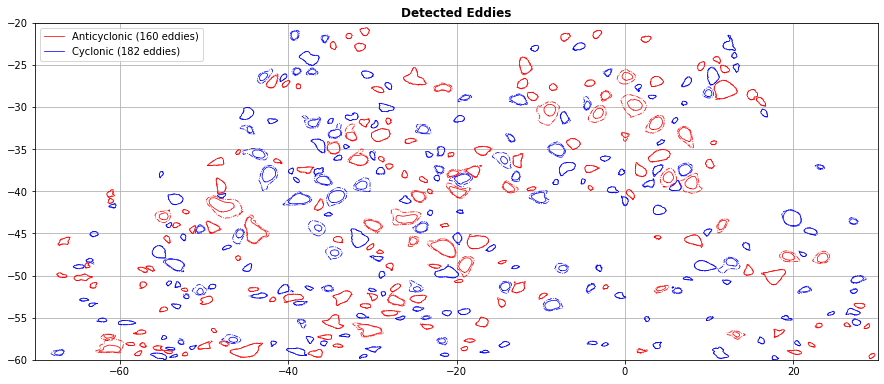

In [43]:
i = 1
lat = [-60, -20]
lon = [-70, 30]
data_addr_nn = '/work/ollie/bpanthi/nn_interpolation_new/ssh_gridded_1961_001_'+str(i).zfill(2)+'_new.nc'
ds = xr.open_dataset(data_addr_nn)
last_day = ds["TIME"].size
days = list(range(1, 2))

eddy_class = eddy_detection(dataset_path=data_addr_nn, lat=lat, lon=lon)

eddy_class.create_list_dataset(days)
print(i)
eddy_class.detect_eddies(30)
print(i)
eddy_class.plot_detected_eddies(days)
#masked_3d_array = masking(eddy_class)


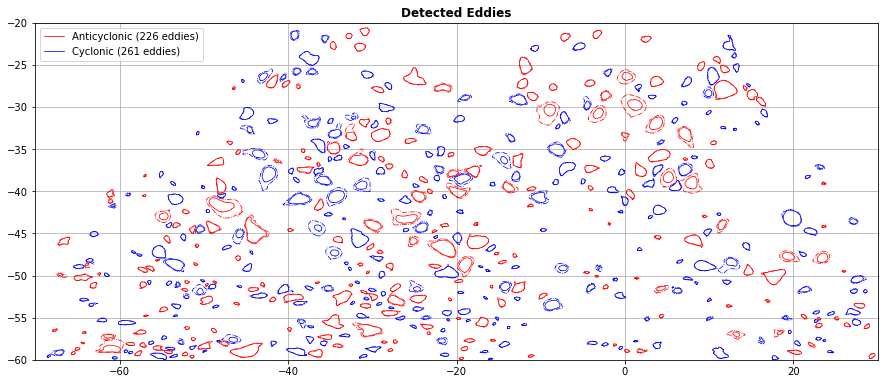

In [41]:
eddy_class.detect_eddies(50)
eddy_class.plot_detected_eddies(days)

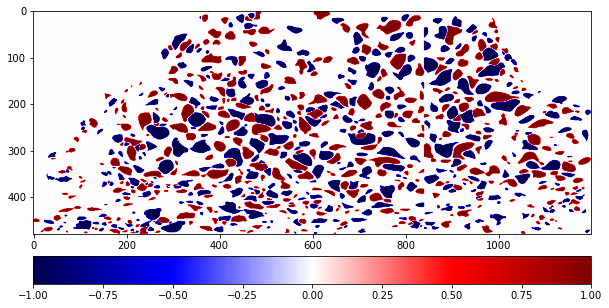

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(np.flipud((-1 * mask_a.T)+mask_c.T), cmap=cm.seismic, vmin=-1, vmax=1)
plt.colorbar(orientation='horizontal', pad=0.04)

In [40]:
counter = 0
for i in (-10 * mask_a.T+mask_c.T).flatten():
    if i == -9:
        counter +=1
print(counter)

0


In [24]:
def generate_pixel_eddy(eddy_class, day):
    g = eddy_class.grid_list[day-1]
    a = eddy_class.anticyclonic_list[day-1]
    c = eddy_class.cyclonic_list[day-1]
    ssh = g.grid("ssh")
    mask_a = np.zeros(ssh.shape, dtype="bool")
    x_a_name, y_a_name = a.intern(False)
    mask_c = np.zeros(ssh.shape, dtype="bool")
    x_c_name, y_c_name = c.intern(False)
    lon = g.x_c
    lon[lon<0] +=360
    g.x_c =lon
    for eddy in a:
        i, j = Path(create_vertice(eddy[x_a_name], eddy[y_a_name])).pixels_in(g)
        mask_a[i, j] = True

    for eddy in c:
        i, j = Path(create_vertice(eddy[x_c_name], eddy[y_c_name])).pixels_in(g)
        mask_c[i, j] = True
    return mask_a, mask_c


In [84]:
def masking(eddy_class):
    masked_anticylonic = []
    masked_cyclonic = []
    masked_total = []
    for day in days:
        mask_a, mask_c = generate_pixel_eddy(eddy_class, day)
        masked_anticylonic.append(mask_a)
        masked_cyclonic.append(mask_c)
        masked_total.append(2 * mask_a + 1 * mask_c)
    masked_3d = np.dstack(masked_total)
    masked_3d = np.rollaxis(masked_3d,-1)
    return masked_3d

masked_3d_array = []
for i in range(1,12):
    masked_3d_array.append(masking(eddy_class_list[i - 1]))



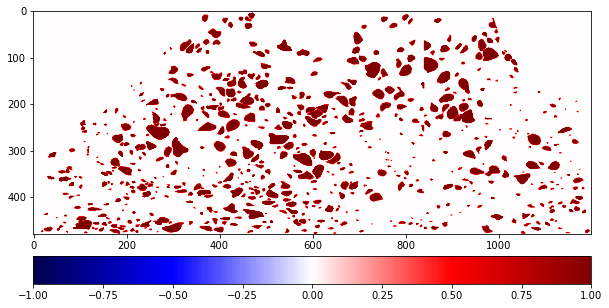

In [87]:
plt.figure(figsize=(10,10))
plt.imshow(np.flipud(masked_3d[:,:,0].T), cmap=cm.seismic, vmin=-1, vmax=1)
plt.colorbar(orientation='horizontal', pad=0.04)

In [97]:
import os
for i in range(1,12):
    ds = xr.open_dataset('/work/ollie/bpanthi/nn_interpolation/ssh_gridded_1961_001_'+str(i)+'_new.nc')
    ds_mask = ds.copy(deep = True)
    ds_mask["seg_mask"] = ("TIME", "LONGITUDE", "LATITUDE"), masked_3d_array[i-1]
    ds_mask = ds_mask.drop("ssh")

    outfile = "/home/ollie/ssunar/segmentation_masks/segmentation_mask_nn_1961_001_"+str(i)+"_new.nc"
    if os.path.isfile(outfile):
        os.remove(outfile)
    ds_mask.to_netcdf(outfile)

<xarray.Dataset>
Dimensions:    (LONGITUDE: 1200, LATITUDE: 480, TIME: 29)
Coordinates:
  * LONGITUDE  (LONGITUDE) float32 -70.0 -69.92 -69.83 ... 29.75 29.83 29.92
  * LATITUDE   (LATITUDE) float32 -60.0 -59.92 -59.83 ... -20.25 -20.17 -20.08
  * TIME       (TIME) float32 9.646e+04 9.648e+04 ... 9.71e+04 9.713e+04
Data variables:
    seg_mask   (TIME, LONGITUDE, LATITUDE) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0

In [100]:
arr = ds_mask.seg_mask[0].to_numpy()

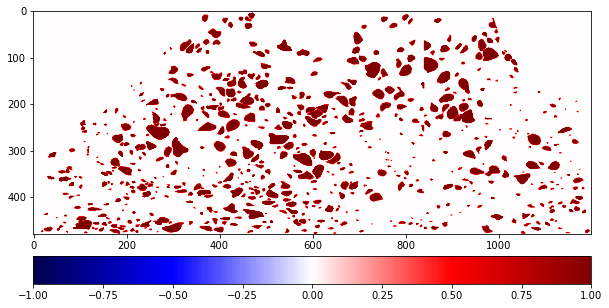

In [101]:
plt.figure(figsize=(10,10))
plt.imshow(np.flipud(arr.T), cmap=cm.seismic, vmin=-1, vmax=1)
plt.colorbar(orientation='horizontal', pad=0.04)

In [102]:
import os
outfile = "/home/ollie/ssunar/segmentation_masks/segmentation_mask_nn_1961_001_1_m.nc"
if os.path.isfile(outfile):
    os.remove(outfile)
ds_mask.to_netcdf(outfile)